In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
%%writefile kaggle.json
{
  "username": "utkrishtnaman",
  "key": "KGAT_d53f04c6ccb0d05cb34d38d52cddea6d"
}


Writing kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets list | head


ref                                                                 title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                                 Chocolate Sales                                         468320  2026-01-04 14:23:35.490000          11308        186  1.0              
ibrahimshahrukh/global-price-of-healthy-diet-dataset                Cost of Healthy Diet by Country (2017-2024)              14103  2026-01-31 02:52:05.010000            459         26  1.0              
rockyt07/social-media-user-analysis                                 Social Media User Analysis                           247842357  2026-01-14 02:28:41.970000           6873        143

In [5]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:26<00:00, 139MB/s]
100% 2.70G/2.70G [00:27<00:00, 107MB/s]


In [6]:
import zipfile

with zipfile.ZipFile("new-plant-diseases-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/data/raw")


In [7]:
!ls /content/data/raw


'new plant diseases dataset(augmented)'   test
'New Plant Diseases Dataset(Augmented)'


In [8]:
TRAIN_DIR = "/content/data/raw/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
VAL_DIR   = "/content/data/raw/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"




In [9]:
import os

print("Train exists:", os.path.exists(TRAIN_DIR))
print("Valid exists:", os.path.exists(VAL_DIR))
print("Train classes:", len(os.listdir(TRAIN_DIR)))
print("Valid classes:", len(os.listdir(VAL_DIR)))


Train exists: True
Valid exists: True
Train classes: 38
Valid classes: 38


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [11]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15


In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

# Store class names here, as they are available on the initial dataset objects
# before prefetching. Both train_ds and val_ds should have the same class names.
class_names = train_ds.class_names

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Rescaling
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

# MobileNetV2 preprocessing
x = Rescaling(1./127.5, offset=-1)(inputs)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)

outputs = Dense(38, activation="softmax")(x)

model = Model(inputs, outputs)


In [16]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("plant_disease_model.keras", save_best_only=True)
]


In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step - accuracy: 0.7822 - loss: 0.7746 - val_accuracy: 0.9243 - val_loss: 0.2198
Epoch 2/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 100s 46ms/step - accuracy: 0.9238 - loss: 0.2318 - val_accuracy: 0.9495 - val_loss: 0.1529
Epoch 3/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - accuracy: 0.9347 - loss: 0.1897 - val_accuracy: 0.9480 - val_loss: 0.1525
Epoch 4/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.9408 - loss: 0.1709 - val_accuracy: 0.9559 - val_loss: 0.1317
Epoch 5/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - accuracy: 0.9469 - loss: 0.1545 - val_accuracy: 0.9571 - val_loss: 0.1294
Epoch 6/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 96s 44ms/step - accuracy: 0.9493 - loss: 0.1456 - val_accuracy: 0.9581 - val_loss: 0.1247
Epoch 7/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.9537 - loss: 0.1351 - val_accuracy: 0.9583 - val_loss: 0.1280
Epoch 8/15
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - accuracy: 0.9546

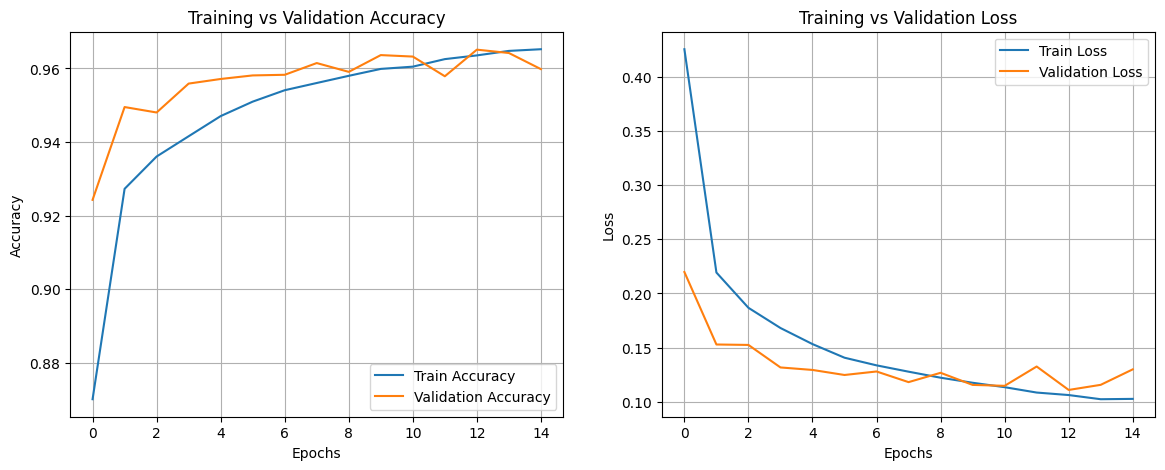

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.show()


In [20]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")


Final Training Accuracy: 96.52%
Final Validation Accuracy: 95.98%


In [21]:
import numpy as np

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


550/550 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step


In [27]:
from sklearn.metrics import classification_report

# class_names was defined earlier from the dataset creation
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.92      0.96       504
                                 Apple___Black_rot       0.97      0.99      0.98       497
                          Apple___Cedar_apple_rust       0.96      0.99      0.98       440
                                   Apple___healthy       0.97      0.99      0.98       502
                               Blueberry___healthy       0.99      1.00      0.99       454
          Cherry_(including_sour)___Powdery_mildew       0.99      1.00      0.99       421
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.90      0.91       410
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.91      0.95      0.

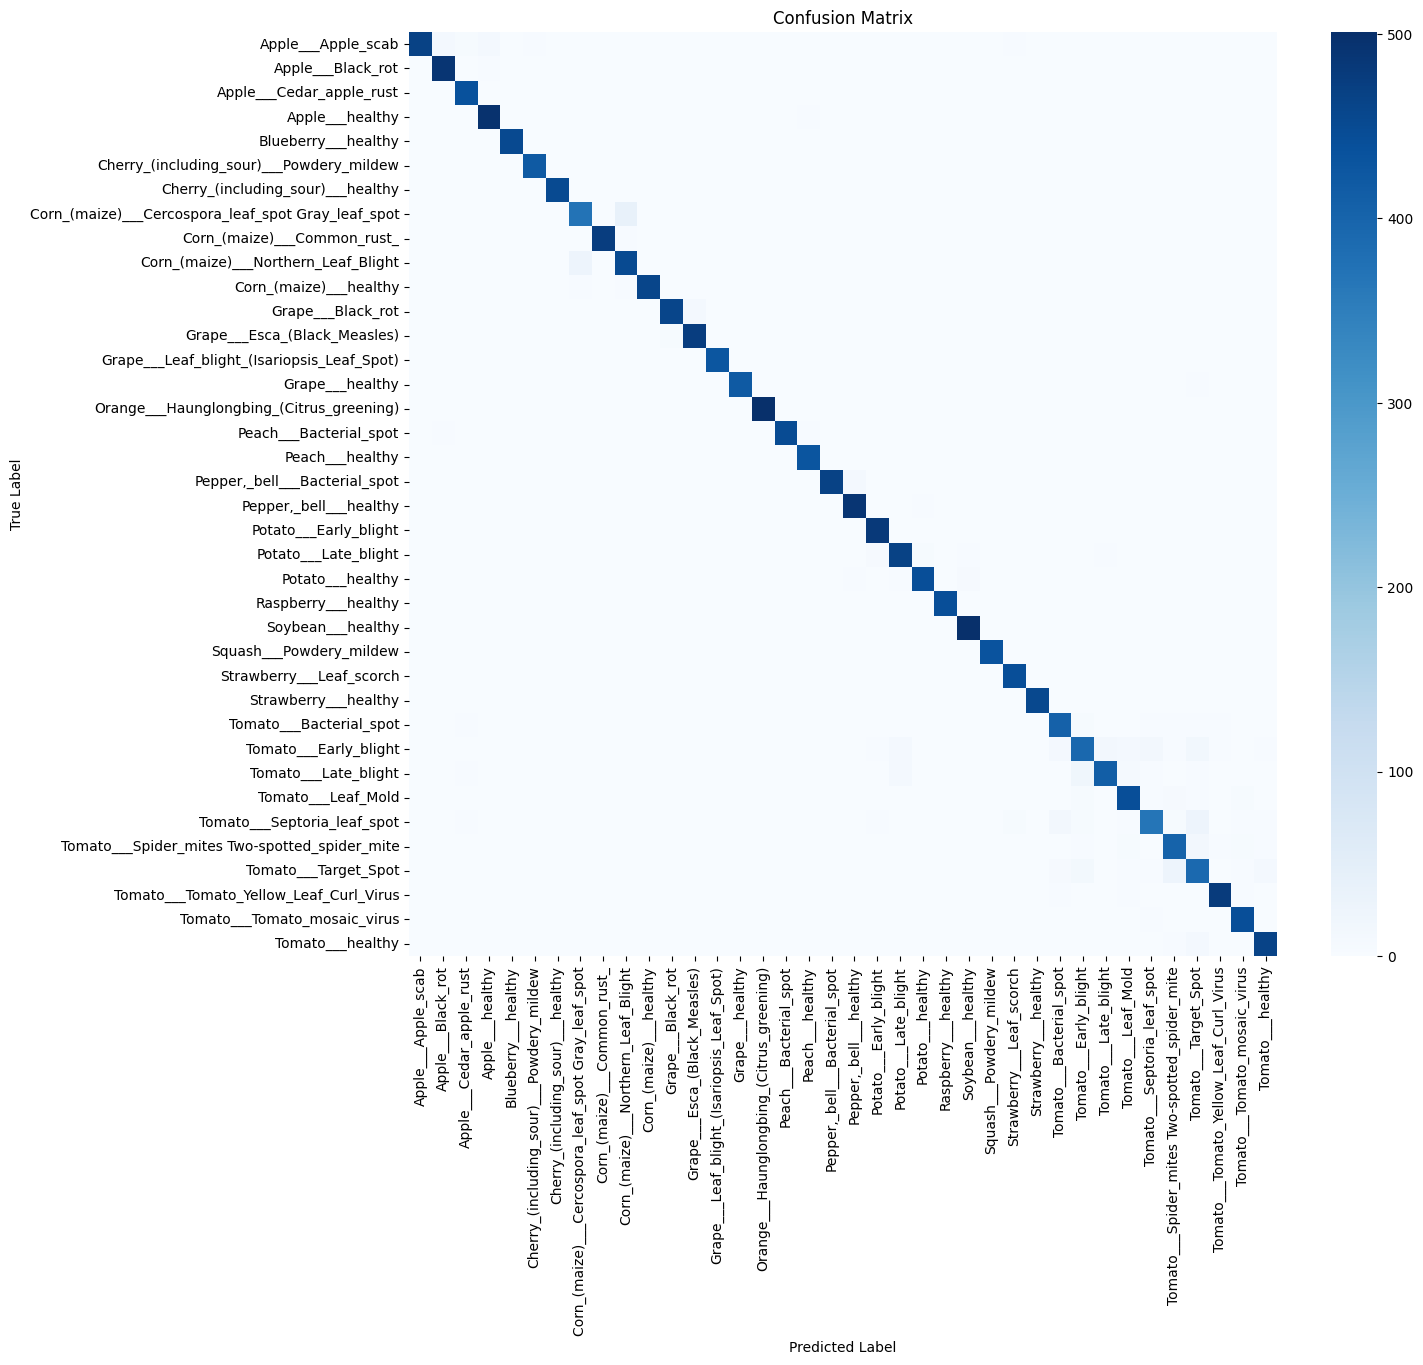

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14,12))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    fmt="d"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


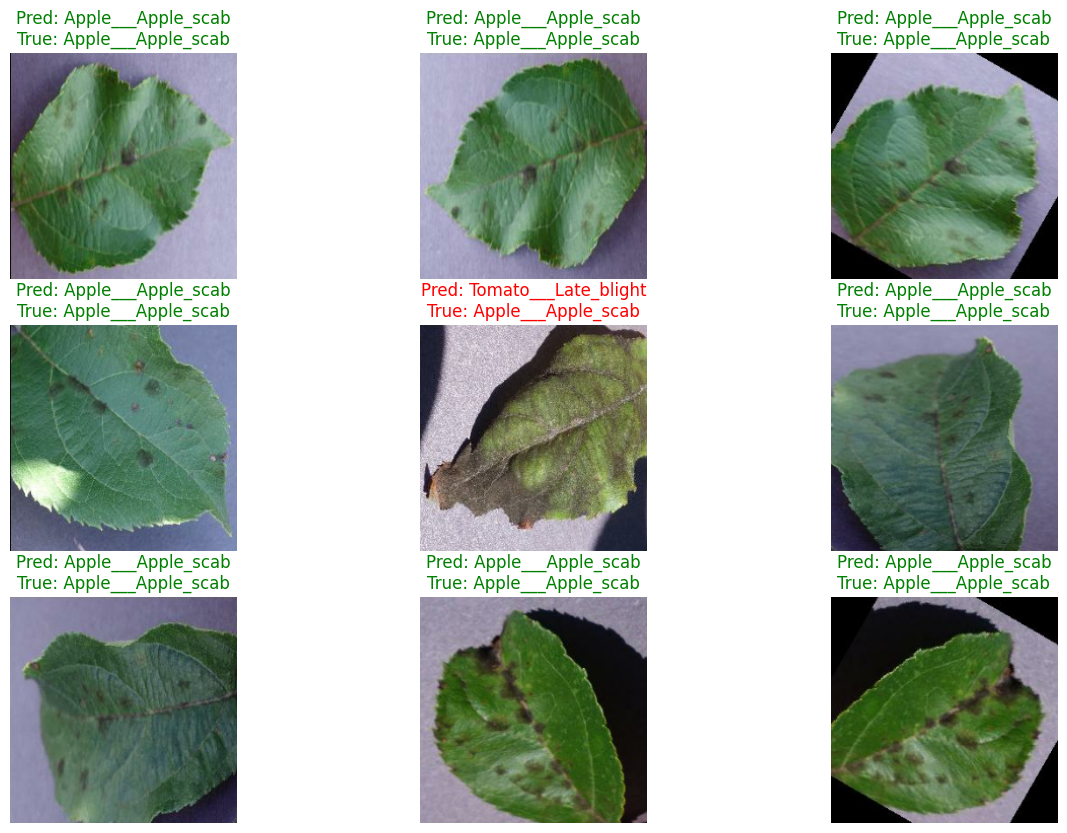

In [29]:
plt.figure(figsize=(15,10))

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(preds[i])]

        title_color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=title_color)
        plt.axis("off")

plt.show()


In [35]:
!ls


class_names.pkl  new-plant-diseases-dataset.zip  sample_data
data		 plant_disease_model.keras


In [32]:
!find /content -name "*.keras"
!find /content -name "*.pkl"


/content/plant_disease_model.keras


In [33]:
import os
import pickle

TRAIN_DIR = "/content/data/raw/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

class_names = sorted(os.listdir(TRAIN_DIR))
print("Number of classes:", len(class_names))


Number of classes: 38


In [34]:
with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)


In [37]:
from google.colab import files

files.download("plant_disease_model.keras")
files.download("class_names.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>